<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/Introduction_to_NLP_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Checking what GPU are we running 
!nvidia-smi

Sun Jun  6 04:51:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy = 'mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [4]:
print(tf.__version__)

2.5.0


### Getting the helper functions 


In [5]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-06-06 04:52:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-06 04:52:04 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
# Import the needed helper functions for the notebook 
from helper_functions import unzip_data , create_tensorboard_callback , plot_loss_curves , compare_historys

## Get a text dataset 

The dataset we're going to be using is Kaggle's Introduction to NLP dataset (text sampels of tweets labelled as disaster (or) not disaster). 

See the original source here https://www.kaggle.com/c/nlp-getting-started/data

In [7]:
# Download the data from Kaggle 
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzipping the data 
unzip_data('nlp_getting_started.zip')

--2021-06-06 04:52:05--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-06-06 04:52:05 (109 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Become one with the data 

We will Visualize , explore our test data in here. 

Text datasets come across in many different formats, aside from CSV files we will probably encounter `.txt` file and `.json` files too. Reading the below articles will help in those times, 
* [How to Read and Write Files in Python](https://realpython.com/read-write-files-python/)
* [Working with JSON Data in Python](https://realpython.com/python-json/)

In [8]:
# Importing pandas to look into our csv file 
import pandas as pd 
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# What's inside our train dataframe? 
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Getting the first sample of row 1 
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

So our goal now is to build a model to predict the target. Where our targets are it is a disaster or not a disaster. 

In [10]:
# Shuffle the traning dataframe 
train_df_shuffled = train_df.sample(frac = 1 , 
                                    random_state = 42)

# Looking into our shuffled dataframe 
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
# What does the test dataframe looks like 
test_df.head() 

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Same as the train dataframe but no targets. In here we are going to use the text column and predict upcoming tweets whether they are Disaster or Not. 

In [12]:
# How many examples of each class? 
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

We can't say our targets are perfectly balanced but it's pretty much a 60-40 split balance between the targets. 

So if we have imabalanced target class refer this https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

In [13]:
# How many total samples in both sets? 

len(train_df) , len(test_df)

(7613, 3263)

In [14]:
# Let's visualize some random training examples. 
import random 

# 5 random index random numbers
# Create random indexes not higher than the total number of samples
random_index = random.randint(0 , len(train_df) - 5) 

# Will return tuples
for row in train_df_shuffled[['text' , 'target']][random_index:random_index+5].itertuples():
  _, text , target = row
  print(f'Target: {target}' , "(real disaster)" if target > 0 else "(not real disaster")
  print(f'Text:\n{text}\n')
  print('----\n')


Target: 1 (real disaster)
Text:
Strawberries are in big trouble. Scientists race to find solution. http://t.co/MqydXRLae7 http://t.co/EpJjkB4Be9

----

Target: 0 (not real disaster
Text:
@matt_bez oh I'm not bagging her at all! Her body be bangin'. I'm saying she's going to get the rose.

----

Target: 1 (real disaster)
Text:
&gt; Bin Laden family plane crashed after 'avoiding microlight and landing too far down runway... http://t.co/Tu9cgLmgVR #rochdale #heywood

----

Target: 1 (real disaster)
Text:
#world FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps  http://t.co/wvExJjRG6E

----

Target: 0 (not real disaster
Text:
Sitting in a cafe enjoying a bite and cramming for my meeting during my whirlwind 14-hours in NYC! https://t.co/TO0BPiEymS

----



Though we have train and test datasets it's good to create an validation dataset. 

### Split data into training and validation set 

In [15]:
from sklearn.model_selection import train_test_split

# Let's split training data into train and val set
train_sentences , val_sentences , train_labels , val_labels = train_test_split(train_df_shuffled['text'].to_numpy() , 
                                                                               train_df_shuffled['target'].to_numpy() , 
                                                                               test_size = 0.1,  # Use 10% of the training data for validation set 
                                                                               random_state = 42)

In [16]:
# Checking the shapes of our splits 

train_sentences.shape , train_labels.shape , val_sentences.shape , val_labels.shape

((6851,), (6851,), (762,), (762,))

In [17]:
# Number of samples 
print(f'Number of sampels in train set: {len(train_sentences)}')
print(f'Number of sampels in validation set: {len(val_sentences)}')

Number of sampels in train set: 6851
Number of sampels in validation set: 762


In [18]:
# Check the first 10 samples 
train_sentences[:10] , train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

Great now we got to know about how our data looks. The next step would be converting our features into numbers where our targets already in number we don't have to bother about it. 

Next step would be turn the text into numbers! 

## Converting text into numbers 

Alright now the challenge is to convert our text into numbers we can use two techniques they are, 

- **Tokenization**
- **Embeddings**

Let's look into them one by one. 

#### Tokenization

A straight mapping from word or character or sub-word to a numerical value. There are three main levels of tokenization: 

- Using **word-level tokenization** with the sentence 'I love TensorFlow' might result in 'I' being `0` , 'love' being `1` and TensorFlow being `2`. In this case, every word in a sequence considered as a single **token.**
- **Character - level tokenization,** such as converting the letters A-Z to values `1-26`. In this case, every character in a sequence (or) considered as a single token.
- **Sub-word tokenization** is in between word-level and character-level tokenization. It involves breaking individual words into smaller parts and then converting those smaller parts into numbers.

    For example ' my favourite food is pineapple pizza' might become —> " my, fav, avour, rite, fo, oo, od, is, pin, ine, app, le, piz, za". After doing this, these sub-words would then be mapped to a numerical value. In this case every word could be considered multiple tokens. 

#### Embeddings

A embedding is a representation of natural language which can be learned. Representation comes in the form of a **feature vector**. For example, the word 'dance' could be represented by the 5-dimensional vector `[-0.8457 , 0.4559 , -0.3332, 0.9877, 0.1112]`. 

It's important to note here, the size of the feature vector is tuneable (embedding_size). There are two ways to use embeddings: 

- **Create your own embedding** - Once your text has been turned into numbers (requires for an embedding), you can put them through an embedding layer (such as `[tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)`) and embedding representation will be learned during model training.
- **Reuse a pre-learned embedding** - Many pre-trained embeddings exist online. These are pre-trained embeddings have often learned on large corpuses of a text (such as all of Wikipedia) and thus have good underlying representation of natural language. You can use pre-trained embedding to initialize your model and fine-tune it to your own specific task.

Example of **tokenization** (straight mapping from word to number) and **embedding** (richer representation of relationships between tokens).

> Question: What level of tokenzation should I use? What embedding should should I choose?

It depends on your problem. You could try character-level tokenization/embeddings and word-level tokenization/embeddings and see which perform best. You might even want to try stacking them (e.g. combining the outputs of your embedding layers using [`tf.keras.layers.concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate) ).

If you're looking for pre-trained word embeddings, [Word2vec embeddings](http://jalammar.github.io/illustrated-word2vec/), [GloVe embeddings](https://nlp.stanford.edu/projects/glove/) and many of the options available on TensorFlow Hub are great places to start.

> Note: Much like searching for a pre-trained computer vision model, you can search for pre-trained word embeddings to use for your problem. Try searching for something like "use pre-trained word embeddings in TensorFlow".

When dealing with a text problem one of the first things you'll have to do before you can build a model is to convert your text to numbers. 

There are few ways to do this, namely: 
* Tokenization - direct mapping of token (a token could be a word or character) to number. 
* Embedding - create a matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned). 

### Text vectorization (tokenization)

In [19]:
# Remind ourselves how our data looks like 
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [20]:
# Import the tokenization layer 
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

How does the `TextVectorization` layer works? 
- standardize each sample (lower casing + punctuation stripping). 
- split each sample into substrings (usually words). 
- recombine substrings into tokens (usually ngrams which will group words). 
- index tokens (assign a unique int value to each token). 
- transform each sample using the index, either into a vector of ints or dense float vector.  

In [21]:
# Use the default TextVectorization parameters 

text_vectorizer = TextVectorization(max_tokens = None , # how many words in the vocabulary (automatically add <OOV>)
                                   standardize = 'lower_and_strip_punctuation' , # Standardize our text data like in image (convert into lower case and strip punctu)
                                   split = 'whitespace', # Split the sequence by whitespace
                                   ngrams = None , # create group of n-words (None will not group them)
                                   output_mode = 'int', # how to map tokens to numbers
                                   output_sequence_length = None, # More like batches (padding) None will pad each sequence to normal sequence
                                   pad_to_max_tokens = True )

We can pad out tweets to the longer sequence but to keep our data small we will find the average words in a sequence and will pad our whole data to it. 

In [22]:
ex = train_sentences[0].split()
len(ex)

7

In [23]:
# Find the average number of tokens (words) in the training tweets. 

round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [24]:
# Setup text vectorization variable 
max_vocab_length = 10000 # Max number of words to have in our vocabulary
max_length = 15 # max length our sequence will be (e.g how many words from Tweet does a model see)

# Creating a instance
text_vectorizer = TextVectorization(max_tokens= max_vocab_length , 
                                    output_mode = 'int' , 
                                    output_sequence_length = max_length)

Now we have a instance of our `TextVectorization` layer now we will have to map this layer to our text data in order to convert them in numerical format. 

We can do this by using `.adapt()` method. 

In [25]:
# Fit the text vectorizer to the training sentence
text_vectorizer.adapt(train_sentences) # Will go through and apply the text vectorization

In [26]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"

# Applying our text vectorization to our above sentence 
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

We can observe that our word got converted into a number and rest 0 is to make sure to (pad) fill up the `output_sequence _length` we mentioned while creating our text vectorization layer. 

In [27]:
# Choose a random sentence from the training dataset and tokenize it 

random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}\
      \n\nVectorized version:')
text_vectorizer([random_sentence])

Original text:
 #Sismo ML 2.4  NEAR THE COAST OF WESTERN TURKEY: MagnitudeåÊåÊML 2.4RegionåÊåÊNEAR THE COAST OF WESTERN TURKEY... http://t.co/0wdAzLcM90 #CS      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1475, 5106, 1335,  217,    2, 1148,    6, 1102,  613,    1,    1,
           2, 1148,    6, 1102]])>

Great, thought our sentence is more than 15+ words long but we want to keep our sequence withing the range 0-15. 

We know that `max_tokens` in our text vectorizer layer, it will help us to keep track of the unique words it come across from our data. 

In [28]:
# Get the unique words in the vocabulary 
words_in_vocab = text_vectorizer.get_vocabulary() # Get all of the unique words in our training data

# Most common words in our vocabulary
top_5_words = words_in_vocab[:5] 

# Least common words in our vocabulary
bottom_5_words = words_in_vocab[-5:]

print(f'Number of words in vocab: {len(words_in_vocab)}')
print(f'5 most common words: {top_5_words}')
print(f'5 least common words: {bottom_5_words}')

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


Number of unique words is **10000** its because that's what we set the max_length to. 

UNK - Unknown vocabulary these are words which isn't in our vocabulary. Like 10000 unique words might not cover all of the words in here. 

So if we increase our `max_length` parameter to 20000 then our text vectorizer can handle more unique values and there will be less [UNK] tokens. 

---

Alright let's try out embedding and we know the best part of embedding is it can be learned. 

### Creating an Embedding using a Embedding Layer 

We have got a way to map our text into numbers. How about we find a way and turn those numbers into embeddings. 

To make our embedding, we're going to use a TensorFlow's embedding layer. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

At first the embedding is created the number are all going to random and we know our embedding layer learns and improves as it goes. Likewise the weights in our model it will get updated to better suit the order of the representation of our words. 

The parameters we care most about for our embedding layer: 
- `input_dim` = the size of our vocabulary
- `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long. 
- `input_lenght` = length of the sequences being passed to the embedding layer (max_length) so it's going to be 15 long. 

In [29]:
# In practice 
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim= max_vocab_length , # set input shape
                             output_dim = 128,  # output shape
                             input_length = max_length # How long each input is
                             )

# Looking at our embedding layer 
embedding

In [30]:
# Get a random sentence from our training sentence 
random_sentence = random.choice(train_sentences)
print(f'Original text:\n {random_sentence}')

# Mapping text into numbers (turn into dense vectors of fixed size)
tokenized_form = text_vectorizer([random_sentence]) 
print(f'\n After turning our text into numbers:\n\n {tokenized_form}')

# Using our embedding layer 
print(f'\nApplying the embedding layer to our tokenized vector\n\n {embedding(tokenized_form)}')

Original text:
 @CarlaChamorros HILLARY A MASS MURDERER.

 After turning our text into numbers:

 [[   1 3777    3  157  538    0    0    0    0    0    0    0    0    0
     0]]

Applying the embedding layer to our tokenized vector

 [[[-0.005024 -0.009796  0.00965  ... -0.007717 -0.02211   0.02553 ]
  [ 0.01373   0.03336   0.03363  ...  0.005196 -0.02548   0.007557]
  [-0.0394   -0.01674   0.0384   ... -0.002893 -0.04794   0.02464 ]
  ...
  [ 0.01663   0.0335   -0.04608  ...  0.02415  -0.02083   0.02797 ]
  [ 0.01663   0.0335   -0.04608  ...  0.02415  -0.02083   0.02797 ]
  [ 0.01663   0.0335   -0.04608  ...  0.02415  -0.02083   0.02797 ]]]


In [31]:
sample_embed = embedding(tokenized_form)
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float16, numpy=
array([[[-0.005024, -0.009796,  0.00965 , ..., -0.007717, -0.02211 ,
          0.02553 ],
        [ 0.01373 ,  0.03336 ,  0.03363 , ...,  0.005196, -0.02548 ,
          0.007557],
        [-0.0394  , -0.01674 ,  0.0384  , ..., -0.002893, -0.04794 ,
          0.02464 ],
        ...,
        [ 0.01663 ,  0.0335  , -0.04608 , ...,  0.02415 , -0.02083 ,
          0.02797 ],
        [ 0.01663 ,  0.0335  , -0.04608 , ...,  0.02415 , -0.02083 ,
          0.02797 ],
        [ 0.01663 ,  0.0335  , -0.04608 , ...,  0.02415 , -0.02083 ,
          0.02797 ]]], dtype=float16)>

What is 128? 
Every single token in our sequence are now in the format of 128 long vectors. 

In [32]:
# Check out a single token's embedding 
sample_embed[0][0] , sample_embed[0][0].shape , random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float16, numpy=
 array([-0.005024, -0.009796,  0.00965 , -0.04703 ,  0.02823 , -0.02725 ,
        -0.00574 , -0.02844 ,  0.0363  ,  0.03293 ,  0.001346, -0.0387  ,
        -0.0266  , -0.02612 , -0.009384,  0.02    ,  0.01526 ,  0.013855,
         0.02634 , -0.0042  ,  0.03284 ,  0.0255  , -0.02672 ,  0.001781,
        -0.0414  ,  0.012276,  0.03105 ,  0.02475 ,  0.04556 , -0.0384  ,
        -0.00925 , -0.03976 ,  0.04822 ,  0.0466  ,  0.03099 ,  0.006214,
        -0.03906 , -0.03093 ,  0.03317 ,  0.00942 ,  0.01113 ,  0.02339 ,
         0.002731, -0.00827 ,  0.02336 , -0.01671 ,  0.003279,  0.005558,
         0.00421 , -0.04288 ,  0.00475 ,  0.03345 ,  0.02403 ,  0.03925 ,
         0.03125 ,  0.005207, -0.00828 ,  0.00285 , -0.003986,  0.03253 ,
        -0.007336,  0.009605, -0.011665, -0.04855 , -0.03174 , -0.02472 ,
        -0.005573, -0.02228 , -0.04205 ,  0.042   , -0.00946 ,  0.03418 ,
        -0.02551 , -0.001414, -0.03998 ,  0.03845 , -0.028   , 

Alright next we wil discuss the various modelling experiments we're going to run. 

## Modelling a text dataset (running a series of experiments) 

Once you've got your inputs and outputs prepared, it's a matter of figuring out which machine learning model to build in between them to bridge the gap.

To get a plenty of practice, we're going to build a series of different models, each has its won experiment. We'll then compare the results of each model and see which one performed better. 

We're going to build, 

- **Model 0**: Naive Bayes (common baseline for text based data- tf-idf)
- **Model 1**: Feed-forward neural network (dense model)
- **Model 2**: LSTM model (RNN)
- **Model 3**: GRU model (RNN)
- **Model 4**: Bidirectional-LSTM model (RNN)
- **Model 5**: 1D Convolutional Neural Network
- **Model 6**: TensorFlow Hub Pre-trained Feature Extractor
- **Model 7**: Same as model 6 with 10% of training data.

How are we going to approach all of these? 
Use the standard steps in modelling with TensorFlow: 
- Create a Model
- Build a Model 
- Fit a model 
- Evaluate our model

Let's build a Non-deeplearning model to be more specific a Naive Bayes model from scikit-learn

Let's experiment before the video 


In [33]:
# Checking the shapes of our splits 
train_sentences.shape , train_labels.shape , val_sentences.shape , val_labels.shape

((6851,), (6851,), (762,), (762,))

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating a instance
tfidf = TfidfVectorizer()

# Fitting our data to our TfidfVectorizer 
tf_transformer = tfidf.fit(train_sentences)

# Applying the transformation
train_sen_trans = tf_transformer.transform(train_sentences)

# Checking the shape 
train_sen_trans.shape

(6851, 20076)

In [35]:
train_sen_trans[:1]

<1x20076 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [36]:
# Importing the naive bayes model for our classified 
from sklearn.naive_bayes import MultinomialNB

# Creating a instance of our model 
clf_naive = MultinomialNB()

# Fitting the data
clf_naive.fit(train_sen_trans , train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Model 0: Getting a baseline 

To create our baseline, we'll use Sklearn's multinomal Naive Bayes using the TF-IDF formula to convert our words to numbers. 

> 🔑 **Note**: It's common practice to use non-DL algorithms as a baseline because of their speed and then later using the DL to see if we can improve. 



In [37]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer # (turn text into numbers)
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                  ('tfidf' , TfidfVectorizer()) , # Convert words to numbers using tfidf
                  ('clf' , MultinomialNB()), # Model the text 
                ])

# Fit the pipeline to the training data 
model_0.fit(train_sentences , train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [39]:
# Evaluate our baseline model 
# Default evaluation metrics is accuracy
baseline_score = model_0.score(val_sentences , val_labels)
print(f'Our baseline mdoel achieves an accuracy of: {baseline_score*100:.2f}%')

Our baseline mdoel achieves an accuracy of: 79.27%


In [40]:
# Make predictions 
baseline_preds = model_0.predict(val_sentences)

# First 10 predictions
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

Let's use some of the other evaluation metrics. We will make a handy function which will help us to reduce the hustle of writing out every evaluation metrics. 

In [41]:
def classification_evaluation_metrics(y_true , 
                                      y_preds):
  '''
  Arguments: 
  y_true --> true labels of the data 
  y_preds --> predicted labels of the data 

  Returns: 
  A dictionary of evaluation metrics like precision , recall and f1_score
  '''

  # Let's first import the needed metrics 
  from sklearn.metrics import precision_score , f1_score , accuracy_score , recall_score

  # Creting the metrics 
  accuracy = accuracy_score(y_true , y_preds)
  f1_score = f1_score(y_true , y_preds)
  precision = precision_score(y_true , y_preds)
  recall = recall_score(y_true , y_preds)

  # Now will create a dictionary of these metrics and pack them
  evaluation_dict = {'Accuracy:': accuracy * 100 , 
                     'F1_Score: ': f1_score , 
                     'Precision: ': precision , 
                     'Recall: ': recall }

  # Return our dictionary 
  return evaluation_dict
  

In [42]:
# Using the above function 
naive_baseline_results = classification_evaluation_metrics(val_labels , 
                                                    baseline_preds)

# Looking into the dictionary of evaluation metrics 
naive_baseline_results

{'Accuracy:': 79.26509186351706,
 'F1_Score: ': 0.734006734006734,
 'Precision: ': 0.8861788617886179,
 'Recall: ': 0.6264367816091954}

Great! Our baseline model worked better than we expected. Now let's build a Feed-forward neural network model for our text data.

### Model 1: Feed Forward Neural Network (Dense layers) 


In [43]:
# Create a tensorboard callback (to track the model experiments) 
# New one for each model
from helper_functions import create_tensorboard_callback

# Create a directory to save tensorboard logs 
SAVE_DIR = 'model_logs'

In [44]:
# Build model with the functional API 
from tensorflow.keras import layers 

# Creating our input layer (inputs are 1D strings)
inputs = layers.Input(shape=(1,) , dtype = tf.string)

# Convert strings into numbers and applying word embedding
x = text_vectorizer(inputs) # turn input text into numbers 
x = embedding(x) # Create an embedding of the numberized inputs 

# Ouput layer (want binary outputs so use sigmoid activation function)
outputs = layers.Dense(1, activation='sigmoid')(x) 

# Packing into a model 
model_1 = tf.keras.Model(inputs , outputs , name = 'model_1_dense')

# Getting the model summary 
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
dense (Dense)                (None, 15, 1)             129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


At `embedding_2 (Embedding)` our embedding layers adds a extra dimension 128 so our model's parameters gets increased in numbers.

Because every single tokens (15 tokens) get represented as 128 long feature vector. 

In [45]:
# Compile the model 
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

In [46]:
# Fit the model 
model_1_history = model_1.fit(train_sentences ,
                              train_labels , 
                              epochs = 5 , 
                              validation_data = (val_sentences , val_labels) , 
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR , 
                                                                       experiment_name = 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20210606-045213
Epoch 1/5
215/215 [==============================] - 7s 18ms/step - loss: 0.6496 - accuracy: 0.6416 - val_loss: 0.6311 - val_accuracy: 0.6475
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5974 - accuracy: 0.6899 - val_loss: 0.6235 - val_accuracy: 0.6487
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5772 - accuracy: 0.6923 - val_loss: 0.6262 - val_accuracy: 0.6468
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5678 - accuracy: 0.6919 - val_loss: 0.6297 - val_accuracy: 0.6481
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.5634 - accuracy: 0.6917 - val_loss: 0.6346 - val_accuracy: 0.6475


In [47]:
# Check the results 
model_1.evaluate(val_sentences , val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.6346 - accuracy: 0.6475


[0.6345682740211487, 0.6475065350532532]

In [48]:
# Make some predictions and evaluate 
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 15, 1)

In [49]:
model_1_pred_probs[:1]

array([[[0.4294 ],
        [0.4294 ],
        [0.4294 ],
        [0.165  ],
        [0.478  ],
        [0.4294 ],
        [0.4294 ],
        [0.4294 ],
        [0.10016],
        [0.3303 ],
        [0.4294 ],
        [0.9473 ],
        [0.03906],
        [0.4294 ],
        [0.335  ]]], dtype=float16)

We want a single prediction probability for each sample but it looks like it is outputing a prediction probability for each tokens.

To fix this we will be using **GlobalAveragePooling** layer. This will help us to condense the feature vector for each token to one vector.

In [50]:
# Let's build the model again but with GlobalAveragePooling 
from tensorflow.keras import layers 

# Input layer
inputs = layers.Input(shape = (1,) , dtype = tf.string)

# Turn text into numbers and create an word embedding 
x = text_vectorizer(inputs)
x = embedding(x)

# Condense the feature vector for each token to "one vector"
x = layers.GlobalAveragePooling1D()(x)

# Output layer 
outputs = layers.Dense(1 , activation = 'sigmoid')(x)

# Packing into a model 
model_1 = tf.keras.Model(inputs , outputs , name = 'model_1_dense')


In [51]:
# Checking the summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Compile the model 
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = 'accuracy')

In [53]:
# Fitting the model 
model_1.fit(train_sentences , 
            train_labels , 
            epochs = 5 , 
            validation_data = (val_sentences , val_labels) , 
            callbacks = create_tensorboard_callback(dir_name= SAVE_DIR , 
                                                    experiment_name = 'model_1_dense_pool_layer'))

Saving TensorBoard log files to: model_logs/model_1_dense_pool_layer/20210606-045234
Epoch 1/5
215/215 [==============================] - 5s 17ms/step - loss: 0.5598 - accuracy: 0.7773 - val_loss: 0.5172 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3931 - accuracy: 0.8533 - val_loss: 0.4613 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3131 - accuracy: 0.8819 - val_loss: 0.4493 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2615 - accuracy: 0.9041 - val_loss: 0.4547 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2223 - accuracy: 0.9207 - val_loss: 0.4666 - val_accuracy: 0.7808


In [54]:
# Checking the results by evaluatiing our model 
model_1.evaluate(val_sentences , val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4666 - accuracy: 0.7808


[0.46662387251853943, 0.7808399200439453]

In [55]:
# Making prediction 
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [56]:
# How our predictions looks now? 
model_1_pred_probs[:10]

array([[0.3733],
       [0.785 ],
       [0.997 ],
       [0.155 ],
       [0.1292],
       [0.9507],
       [0.9053],
       [0.996 ],
       [0.974 ],
       [0.2788]], dtype=float16)

In [57]:
# Convert model prediction probs to label format 

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float16, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float16)>

In [58]:
# Calculate our model_1 results 
model_1_results = classification_evaluation_metrics(y_true = val_labels , 
                                                    y_preds = model_1_preds)

model_1_results

{'Accuracy:': 78.08398950131233,
 'F1_Score: ': 0.7418856259659969,
 'Precision: ': 0.802675585284281,
 'Recall: ': 0.6896551724137931}

In [59]:
# Our baseline metrics 
naive_baseline_results

{'Accuracy:': 79.26509186351706,
 'F1_Score: ': 0.734006734006734,
 'Precision: ': 0.8861788617886179,
 'Recall: ': 0.6264367816091954}

In [60]:
# Comparing our base line model with our deeplearning model
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(naive_baseline_results.values()))

array([False,  True, False,  True])

### Visualizing our model's learned word embeddings with TensorFlow's projector tool

In [61]:
# Get the vocabulary from the text vectorization layer 

# Getting the unique vocabulary our embedding layer learnt
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab) , words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [62]:
# Model 1 summary (inspect the embedding layer)
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


Let's get the weight matrix of our embedding layer 

These are the numerical representation of each token in our training data, which have been learned for 5 epochs (patterns from our embedding layer). 

In [63]:
embed_weights = model_1.get_layer('embedding').get_weights()
embed_weights

[array([[-2.10032295e-02, -7.21996231e-03, -8.56838375e-02, ...,
         -1.68908797e-02,  1.56034967e-02,  6.78348169e-02],
        [-1.73198115e-02, -2.49195062e-02, -6.18463708e-03, ...,
         -2.29640789e-02, -7.98925851e-03,  4.15565223e-02],
        [-6.16898686e-02, -6.00562282e-02, -8.14142972e-02, ...,
         -2.60837004e-02,  4.00570855e-02,  1.20559391e-02],
        ...,
        [ 2.56976150e-02,  1.45889819e-04, -1.93693880e-02, ...,
          3.18979733e-02, -3.92366759e-02,  3.38860042e-02],
        [-9.46974680e-02, -5.29922545e-02, -7.91671649e-02, ...,
         -1.02913074e-01,  1.20487392e-01,  7.10639656e-02],
        [-1.23542853e-01, -1.01165108e-01, -1.25926480e-01, ...,
         -1.22870386e-01,  9.89418924e-02,  1.49825722e-01]], dtype=float32)]

Those are the weights learned by our embedding layers. 

In [64]:
# The shape should be same size as vocab and embedding_dim (output_dim of our embedding layer)
embed_weights[0].shape 

(10000, 128)

From above we can understand that,
1000 from every token is embedded into 128 dimension vector. 

Now we've got the embeddig matrix of our model has learned to represent our tokens, let's see how we visualize it. 

To do so, TensorFlow has a handy tool called projector: http://projector.tensorflow.org/_

And TensorFlow also has a guide on Word Embeddings: https://www.tensorflow.org/tutorials/text/word_embeddings

In [65]:
# Create embedding files (we got this from TensorFlow's word embeddings documentation)

import io 
# Creating a vector and metadata file for our embeddings (tokens and words)
out_v = io.open('vectors.tsv' , 'w' , encoding = 'utf-8')
out_m = io.open('metadata.tsv' , 'w' , encoding = 'utf-8')

# Loop through and write our values to the corresponding files we created above 
for index , word in enumerate(words_in_vocab):
  if index == 0:
    continue # Skip 0, its padding
  
  vec = embed_weights[0][index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + '\n')

out_v.close()
out_m.close()




In [66]:
# Download files from Colab to upload to the projector 
try: 
  from google.colab import files 
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception: 
  pass  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> Resources: To learn more about embedding, 
* Jay Alamars visualized word2vec: https://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embedding guide: https://www.tensorflow.org/tutorials/text/word_embeddings

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of previous inputs to aid the representation of the later input. 

Use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

> Resources to look into for learning RNN's 
- [RNN MIT Intro to deeplearning](https://www.youtube.com/watch?v=qjrad0V0uJE&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2)
- [Understanding LSTMS](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Unreasonable effectiveness of RNN](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)



### Model 2: LSTM 

LSTM = long short term memory (one of the most popular LSTM cells). 

Our structure of a RNN typically looks like this: 

```
Input (text) --> Tokenize --> Embedding --> Layers (RNNs/dense) --> Output (label probability)
```


In [67]:
# Create an LSTM model 
from tensorflow.keras import layers 

# Setting up inputs 
inputs = layers.Input(shape = (1,) , dtype = tf.string)

# Converting text into numbers and creating a embedding 
x = text_vectorizer(inputs)
x = embedding(x)
print(f'After embedding: {x.shape}')

# Our LSTM 
#x = layers.LSTM(64 , return_sequences=True)(x) 
# When you're stacking RNN cells together you need to set return_sequences = True
#print(f'Output with return sequence True: {x.shape}') # Output with return sequence True
x = layers.LSTM(64)(x)
#print(f'Output with return sequence False: {x.shape}') # Output with return sequence False
x = layers.Dense(64 , activation = 'relu')(x)

# Initializing our outputs 
outputs = layers.Dense(1 , activation = 'sigmoid')(x)

# Packing into a model 
model_2 = tf.keras.Model(inputs , outputs, name = 'model_2_LSTM')

After embedding: (None, 15, 128)


`inputs`: A 3D tensor with shape `[batch, timesteps, feature]`.

- batch --> None by default
- timestaps --> treat every sequence (word) as a timestamps. 

The default activation function for LSTM is **`tanh`**. 

[LSTM layer tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

In [68]:
# Checking the model summary 
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,333,633
Trainable params: 1,333,633
Non-trainable params: 0
____________________________________________

In [69]:
# Compile the model 
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy()  , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

In [70]:
# Fit the model 
model_2_history = model_2.fit(train_sentences , 
                              train_labels , 
                              validation_data = (val_sentences , val_labels) , 
                              epochs = 5 , 
                              callbacks = [create_tensorboard_callback(dir_name= SAVE_DIR , 
                                                                       experiment_name = 'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210606-045252
Epoch 1/5
215/215 [==============================] - 10s 21ms/step - loss: 0.1998 - accuracy: 0.9261 - val_loss: 0.6120 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1346 - accuracy: 0.9488 - val_loss: 0.6413 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1066 - accuracy: 0.9607 - val_loss: 0.7542 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0855 - accuracy: 0.9661 - val_loss: 0.9188 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0698 - accuracy: 0.9712 - val_loss: 1.1152 - val_accuracy: 0.7664


In [71]:
# Make predictions with LSTM model 
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[1.965e-03],
       [8.789e-01],
       [1.000e+00],
       [5.560e-02],
       [1.987e-04],
       [1.000e+00],
       [1.153e-01],
       [1.000e+00],
       [1.000e+00],
       [4.321e-01]], dtype=float16)

In [72]:
# Convert model 2 pred probs to labels 
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float16)>

In [73]:
# Calculate model 2 results 
model_2_results = classification_evaluation_metrics(val_labels , 
                                                    model_2_preds)
model_2_results

{'Accuracy:': 76.64041994750657,
 'F1_Score: ': 0.7244582043343654,
 'Precision: ': 0.785234899328859,
 'Recall: ': 0.6724137931034483}

In [74]:
naive_baseline_results

{'Accuracy:': 79.26509186351706,
 'F1_Score: ': 0.734006734006734,
 'Precision: ': 0.8861788617886179,
 'Recall: ': 0.6264367816091954}

### Model 3: GRU Model 

The GRU cell has similar features to an LSTM cell but has less parameters. 

[Understanding GRU networks](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be)

Previously we used a LSTM layers to build our RNN model now we will use a GRU layer also called Gater Recurrent Unit to build our model. 

In [75]:
# Create a GRU model 
inputs = layers.Input(shape = (1,) , dtype = tf.string)

# Converting text into numbers and performing word embeddings. 
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)

# Building our GRU model 
# If you want to stack recurrent layers on top of each other, you need return_sequences = True
x = layers.GRU(64 , activation = 'tanh' , return_sequences=True)(x)
print(x.shape)
x = layers.LSTM(44 , return_sequences= True)(x) 
print(x.shape)
x = layers.GRU(100)(x)
print(x.shape)
x = layers.Dense(64 , activation='relu')(x)

# Global Average Pooling layer
#x = layers.GlobalAveragePooling1D()(x)

# Output layer 
outputs = layers.Dense(1 , activation= 'sigmoid')(x)

# Packing into a model 
test_model_3 = tf.keras.Model(inputs , outputs)

(None, 15, 128)
(None, 15, 64)
(None, 15, 44)
(None, 100)


In [76]:
# Summary of the mdoel 
test_model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 15, 64)            37248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 44)            19184     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               43800     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464  

Alright we did some tinkering up there, now let's create a model 3 with only one GRU layer

In [77]:
# Creating a GRU model 
from tensorflow.keras import layers 

# Input layer 
inputs = layers.Input(shape = (1,) , dtype = tf.string)

# Converting text into numbers and perform word embeddings 
x = text_vectorizer(inputs)
x = embedding(x)

# Our GRU layer 
#x = layers.GRU(64 , activation= 'tanh' , return_sequences= True)(x)
x = layers.GRU(64)(x)

# Global Average Pooling 
#x = layers.GlobalAveragePooling1D()(x)

# Output layer 
outputs = layers.Dense(1 , activation='sigmoid')(x)

# Packing into a model
model_3 = tf.keras.Model(inputs , outputs) 


In [78]:
# Model summary 
model_3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Compile the model 
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy']) 

In [80]:
# Fit the model 
model_3_history = model_3.fit(train_sentences , 
                              train_labels , 
                              validation_data = (val_sentences , val_labels), 
                              epochs = 5 , 
                              callbacks = [create_tensorboard_callback(dir_name= SAVE_DIR , 
                                                                       experiment_name = 'model_3_GRU')]) 


Saving TensorBoard log files to: model_logs/model_3_GRU/20210606-045337
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.1587 - accuracy: 0.9383 - val_loss: 0.7006 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0806 - accuracy: 0.9707 - val_loss: 0.7795 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0669 - accuracy: 0.9736 - val_loss: 0.9729 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0564 - accuracy: 0.9765 - val_loss: 1.0678 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0511 - accuracy: 0.9780 - val_loss: 1.1163 - val_accuracy: 0.7782


In [81]:
# Making predictions on the val set 
model_3_pred_probs = model_3.predict(val_sentences) 
model_3_pred_probs[:10]

array([[2.262e-03],
       [7.310e-01],
       [1.000e+00],
       [7.996e-02],
       [1.293e-04],
       [1.000e+00],
       [9.419e-01],
       [1.000e+00],
       [1.000e+00],
       [8.052e-01]], dtype=float16)

In [82]:
# Convert model 3 pred probs to labels 
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [83]:
# Using our evalution metrics dictionary 
model_3_results = classification_evaluation_metrics(val_labels , 
                                                    model_3_preds)

In [84]:
model_3_results

{'Accuracy:': 77.82152230971128,
 'F1_Score: ': 0.7443267776096822,
 'Precision: ': 0.7859424920127795,
 'Recall: ': 0.7068965517241379}

### Model 4: Bidirectional RNN Model 

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right. 

A birdirectional wrapper works for any RNN cells. 

Let's give a try before watching the video.  

In [85]:
# Creating a Bidirectional RNN model 
from tensorflow.keras import layers
# Input layer 
inputs = layers.Input(shape = (1, ) , dtype = tf.string)

# Convert text into numbers and perform word embeddings 
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)

# Adding a Bidirectional RNN layer 
x = layers.Bidirectional(layers.LSTM(64 , return_sequences=True))(x)
print(x.shape)

x = layers.Bidirectional(layers.GRU(64))(x)
print(x.shape)

# Output layer 
outputs = layers.Dense(1 , activation= 'sigmoid')(x)
print(outputs.shape)

# Packing into a model 
test_model_4 = tf.keras.Model(inputs , outputs)

(None, 15, 128)
(None, 15, 128)
(None, 128)
(None, 1)


Here we have added `return_sequence = True` because we want to stack another RNN layer with our current RNN layer. 

In [86]:
# Model summary 
test_model_4.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 1,453,441
Trainable params: 1,453,441
Non-trainable params: 0
_________________________________________________

Following the video 


In [87]:
# Creating a Bidirectional RNN model 
from tensorflow.keras import layers
# Input layer 
inputs = layers.Input(shape = (1, ) , dtype = tf.string)

# Convert text into numbers and perform word embeddings 
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)

# Adding a Bidirectional RNN layer 
x = layers.Bidirectional(layers.LSTM(64 , return_sequences=True))(x)
print(x.shape)
x = layers.Bidirectional(layers.GRU(64))(x)
print(x.shape)

# Output layer 
outputs = layers.Dense(1 , activation= 'sigmoid')(x)
print(outputs.shape)

# Packing into a model 
model_4 = tf.keras.Model(inputs , outputs)

(None, 15, 128)
(None, 15, 128)
(None, 128)
(None, 1)


In [88]:
# Model Summary 
model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 1,453,441
Trainable params: 1,453,441
Non-trainable params: 0
_________________________________________________

Bidirectional wrapper doubles the units so the representation will go from **64 to 128**. 

Bidirectional --> representation gets doubled

In [89]:
# Compile the model 
model_4.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

In [90]:
# Fit the model 
model_4_history = model_4.fit(train_sentences , 
                              train_labels , 
                              validation_data = (val_sentences , val_labels) , 
                              epochs = 5 , 
                              callbacks = [create_tensorboard_callback(dir_name= SAVE_DIR , 
                                                                       experiment_name = 'model_4_bidirectional')])


Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210606-045359
Epoch 1/5
215/215 [==============================] - 12s 31ms/step - loss: 0.0924 - accuracy: 0.9689 - val_loss: 1.1260 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0528 - accuracy: 0.9765 - val_loss: 1.2589 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0449 - accuracy: 0.9794 - val_loss: 1.3206 - val_accuracy: 0.7795
Epoch 4/5
215/215 [==============================] - 5s 22ms/step - loss: 0.0429 - accuracy: 0.9803 - val_loss: 1.4612 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0368 - accuracy: 0.9815 - val_loss: 1.5821 - val_accuracy: 0.7598


Usually adding a bidirectional to a sequences increase the trainin time. 

In [91]:
# Make predictions without our model 4 
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[2.013e-01],
       [8.423e-01],
       [1.000e+00],
       [2.554e-01],
       [3.242e-05],
       [1.000e+00],
       [9.980e-01],
       [1.000e+00],
       [1.000e+00],
       [1.000e+00]], dtype=float16)

In [92]:
# Convert pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [93]:
# Calculate the results of our bidirectional model 
model_4_results = classification_evaluation_metrics(val_labels , 
                                                    model_4_preds)
model_4_results

{'Accuracy:': 75.98425196850394,
 'F1_Score: ': 0.7404255319148935,
 'Precision: ': 0.7310924369747899,
 'Recall: ': 0.75}

Hmm.. Our bidirectional model is performing worse than our uni-directional models. 

We should emphasize from this that not all experiments will go well. 

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNN's for images but images are typically 2D (height x width).... however, our text data is 1D. 

Previously we've used Conv2D for our image data but now we're going to use Conv1D. 

The typical structure of a Conv1D model for sequences (in our case, text): 
```
Inputs (text) --> Tokenization --> Embedding --> Layer(s) (typically Conv1D + pooling) --> Outputs (class probabilities)
```

https://stackoverflow.com/questions/42883547/intuitive-understanding-of-1d-2d-and-3d-convolutions-in-convolutional-neural-n

## Model 5: Conv1D



In [94]:
# Test our our embedding layer , COnv1D layer and max pooling (Let's look into inputs and outputs)
from tensorflow.keras import layers
# Turn target sequence into a embedding
embedding_test = embedding(text_vectorizer(['this is a test sentence']))

# Building a Conv1D layer
conv_1d = layers.Conv1D(filters = 32 , 
                        kernel_size = 5 , # this is salso referred to as ngrams of 5 (means group of 5 words at a time)
                        activation = 'relu' , 
                        padding = 'valid')

# Conv1D output 
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer

# Poolin layer 
max_pool = layers.GlobalMaxPool1D()

# Output of our max pool layer 
# equivalent to get the most important features (or) get the features with highest value
max_pool_output = max_pool(conv_1d_output)

In [95]:
# Checking the shapes 
embedding_test.shape , conv_1d_output.shape , max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [96]:
# Our embedding text
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float16, numpy=
array([[[-0.0547  , -0.0659  , -0.105   , ...,  0.00571 , -0.0649  ,
          0.0919  ],
        [-0.0866  , -0.0779  , -0.03117 , ..., -0.0707  ,  0.05228 ,
         -0.003128],
        [-0.09155 , -0.0555  ,  0.01539 , ..., -0.05893 , -0.04358 ,
          0.04276 ],
        ...,
        [-0.01408 , -0.03009 , -0.03403 , ..., -0.01611 ,  0.003025,
          0.0421  ],
        [-0.01408 , -0.03009 , -0.03403 , ..., -0.01611 ,  0.003025,
          0.0421  ],
        [-0.01408 , -0.03009 , -0.03403 , ..., -0.01611 ,  0.003025,
          0.0421  ]]], dtype=float16)>

In [97]:
# Our Conv1D output 
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float16, numpy=
array([[[0.       , 0.0349   , 0.01683  , 0.04355  , 0.       ,
         0.0894   , 0.038    , 0.       , 0.01741  , 0.0781   ,
         0.       , 0.       , 0.0639   , 0.02168  , 0.02248  ,
         0.06143  , 0.007637 , 0.01692  , 0.       , 0.0727   ,
         0.       , 0.0868   , 0.1613   , 0.       , 0.       ,
         0.       , 0.05475  , 0.02026  , 0.08746  , 0.       ,
         0.       , 0.0244   ],
        [0.       , 0.0779   , 0.       , 0.02107  , 0.05988  ,
         0.       , 0.01047  , 0.0003817, 0.0535   , 0.01906  ,
         0.       , 0.       , 0.       , 0.03552  , 0.       ,
         0.002104 , 0.001564 , 0.0745   , 0.02745  , 0.02847  ,
         0.0795   , 0.03918  , 0.03091  , 0.       , 0.       ,
         0.       , 0.0139   , 0.       , 0.03802  , 0.0957   ,
         0.       , 0.       ],
        [0.       , 0.       , 0.       , 0.1337   , 0.       ,
         0.       , 0.       , 0.       , 0.03964  

In [98]:
# Condense our conv1d 
# We take max across [1 , 15 , 64] and condense into 
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float16, numpy=
array([[0.00475 , 0.0779  , 0.0597  , 0.1337  , 0.05988 , 0.0894  ,
        0.038   , 0.004467, 0.0535  , 0.0781  , 0.      , 0.0381  ,
        0.0874  , 0.03552 , 0.02248 , 0.06143 , 0.007637, 0.0745  ,
        0.093   , 0.0727  , 0.0795  , 0.089   , 0.1613  , 0.01197 ,
        0.      , 0.0341  , 0.05475 , 0.02026 , 0.0985  , 0.1029  ,
        0.      , 0.04208 ]], dtype=float16)>

Taking on the challenge and building a Conv1D model 

In [99]:
# Creating Conv1D sequence model 
inputs = layers.Input(shape = (1, ) , dtype = tf.string)

x = text_vectorizer(inputs)
x = embedding(x)
print(f'Shape after embedding: {x.shape}')

# Our Conv1D layer 
x = layers.Conv1D(filters = 32 , 
                  kernel_size = 5 , 
                  padding = 'same' , 
                  activation = 'relu')(x)
print(f'Shape after Conv1D: {x.shape}')
x = layers.Dense(64 , activation= 'relu')(x)
print(f'Shape after into the Dense layer: {x.shape}')
# GlobalMaxPool1D works better
x = layers.GlobalMaxPool1D()(x)
print(f'Shape after into the GlobalMaxPool layer: {x.shape}')

# Output layer 
outputs = layers.Dense(1 , activation= 'sigmoid')(x)

# Packing into a model 
test_model_5 = tf.keras.Model(inputs , outputs)


Shape after embedding: (None, 15, 128)
Shape after Conv1D: (None, 15, 32)
Shape after into the Dense layer: (None, 15, 64)
Shape after into the GlobalMaxPool layer: (None, 64)


In [100]:
# Compile the model 
test_model_5.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                   optimizer = tf.keras.optimizers.Adam() ,
                   metrics = ['accuracy'])

In [101]:
# Fitting the model 
test_model_5.fit(train_sentences , 
                 train_labels , 
                 validation_data = (val_sentences , val_labels), 
                 epochs = 5 )

Epoch 1/5
215/215 [==============================] - 6s 18ms/step - loss: 0.1211 - accuracy: 0.9645 - val_loss: 0.9255 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0617 - accuracy: 0.9765 - val_loss: 1.0244 - val_accuracy: 0.7559
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0535 - accuracy: 0.9778 - val_loss: 1.2176 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0459 - accuracy: 0.9803 - val_loss: 1.2438 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0432 - accuracy: 0.9810 - val_loss: 1.1624 - val_accuracy: 0.7703


Now following the video 


In [102]:
# Creating Conv1D sequence model 
inputs = layers.Input(shape = (1, ) , dtype = tf.string)

x = text_vectorizer(inputs)
x = embedding(x)
print(f'Shape after embedding: {x.shape}')

# Our Conv1D layer 
x = layers.Conv1D(filters = 32 , 
                  kernel_size = 5 , 
                  padding = 'same' , 
                  activation = 'relu')(x)
print(f'Shape after Conv1D: {x.shape}')
#x = layers.Dense(64 , activation= 'relu')(x)
#print(f'Shape after into the Dense layer: {x.shape}')
# GlobalMaxPool1D works better
x = layers.GlobalMaxPool1D()(x)
print(f'Shape after into the GlobalMaxPool layer: {x.shape}')

# Output layer 
outputs = layers.Dense(1 , activation= 'sigmoid')(x)

# Packing into a model 
model_5 = tf.keras.Model(inputs , outputs , name = 'model_5_conv_1d')


Shape after embedding: (None, 15, 128)
Shape after Conv1D: (None, 15, 32)
Shape after into the GlobalMaxPool layer: (None, 32)


In [103]:
# Compile the model 
model_5.compile(loss = tf.keras.losses.BinaryCrossentropy(), 
                   optimizer = tf.keras.optimizers.Adam() ,
                   metrics = ['accuracy'])

In [104]:
model_5.summary()

Model: "model_5_conv_1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 32)            20512     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
_________________________________________

In [105]:
# Fitting the model 
model_5.fit(train_sentences , 
                 train_labels , 
                 validation_data = (val_sentences , val_labels), 
                 epochs = 5 , 
            callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR , 
                                                     experiment_name = 'model_5_1d_conv_layer')])

Saving TensorBoard log files to: model_logs/model_5_1d_conv_layer/20210606-045516
Epoch 1/5
215/215 [==============================] - 5s 20ms/step - loss: 0.1035 - accuracy: 0.9664 - val_loss: 0.8781 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0533 - accuracy: 0.9783 - val_loss: 1.0289 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0468 - accuracy: 0.9807 - val_loss: 1.1177 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0432 - accuracy: 0.9823 - val_loss: 1.1731 - val_accuracy: 0.7572
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0429 - accuracy: 0.9818 - val_loss: 1.2141 - val_accuracy: 0.7480


In [106]:
# Make some predictions with our Conv1D model 
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[0.03644],
       [0.6616 ],
       [1.     ],
       [0.04434],
       [0.     ],
       [0.995  ],
       [0.9316 ],
       [1.     ],
       [1.     ],
       [0.766  ]], dtype=float16)

In [107]:
# Convert model 5 pred probs to labels 
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float16)>

In [108]:
# Evaluate model 5 predictions 
model_5_results = classification_evaluation_metrics(val_labels , 
                                                    model_5_preds)

In [109]:
model_5_results

{'Accuracy:': 74.80314960629921,
 'F1_Score: ': 0.709090909090909,
 'Precision: ': 0.75,
 'Recall: ': 0.6724137931034483}

In [110]:
# Our base line model 
naive_baseline_results

{'Accuracy:': 79.26509186351706,
 'F1_Score: ': 0.734006734006734,
 'Precision: ': 0.8861788617886179,
 'Recall: ': 0.6264367816091954}

##   Using TensorFlow Hub for pretrained word embeddings (transfer learning for NLP)


For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

We have built few of our own models, now let's use a pretrained one.

Now we're gonna build a feature extractor called USE that is Universal Sentence Encoder.
- **Encoder** —> Encodes sequence into numerical representation.
- **Decoder** —> Decode sequence into a desired output.

More specifically, we're going to be using the [Universal Sentence Encoder](https://tfhub.dev/google/collections/universal-sentence-encoder/1)from TensorFlow Hub (a great resource containing a plethora of pretrained model resources for a variety of tasks).

In [111]:
sample_sentence

"There's a flood in my street!"

In [112]:
# Importing the tensorflow hub 
import tensorflow_hub as hub 
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

# Getting a glimpse of the pretrained model 
embed_samples = embed([sample_sentence , 
                       'When you call a universal sentence encoder on a sentence, it turns it into a numbers.'])
print(embed_samples)

tf.Tensor(
[[-0.01157027  0.0248591   0.02878048 ... -0.00186125  0.02315824
  -0.01485021]
 [ 0.02950276 -0.08060793 -0.01373591 ... -0.0278922   0.02430332
  -0.0008201 ]], shape=(2, 512), dtype=float32)


It turned our sentence into a numerical representation. 

In [113]:
# Shape of the embed_sample 
embed_samples[0].shape

TensorShape([512])

**Creating a Keras layer using USE pre-trained layer from tensorflow hub.**

We can use the link of the pre-trained model and use it in a Keras layer and turn this into. feature extractor layer. 

In [114]:
# Creating a Keras layer 
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4' , 
                                        input_shape = [] , # Defining a input shape so our layer will take anything sequence as a input (any variable length)
                                        dtype = tf.string , 
                                        trainable = False , 
                                        name = 'USE_Layer'
                                        )

In [115]:
# Create model using Sequential API 
model_6 = tf.keras.Sequential([
  # We don't need a text vectorizer and embedding layer this will take care of the pre processing behind the scenes
  sentence_encoder_layer, 
  #layers.Dense(64 , activation = 'relu'), 
  layers.Dense(1 , activation ='sigmoid')
]  , name = 'model_6_USE')

# Compiling the model 
model_6.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])
# Model 6 summary 
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_Layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [116]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_Layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [117]:
# Train a classifier on top of USE pretrained embeddings 
model_6_history = model_6.fit(train_sentences , 
                              train_labels , 
                              epochs = 5 , 
                              validation_data = (val_sentences , val_labels), 
                              callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR , 
                                                                       experiment_name = 'tf_hub_sentence_encoder')])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210606-045557
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.6484 - accuracy: 0.7313 - val_loss: 0.6141 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.5811 - accuracy: 0.7851 - val_loss: 0.5645 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.5384 - accuracy: 0.7921 - val_loss: 0.5326 - val_accuracy: 0.7861
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.5098 - accuracy: 0.7978 - val_loss: 0.5116 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4898 - accuracy: 0.8006 - val_loss: 0.4972 - val_accuracy: 0.7900


In [118]:
# Does it beating our baseline model? 
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:5]

array([[0.3733],
       [0.6733],
       [0.8643],
       [0.3525],
       [0.6406]], dtype=float16)

In [119]:
# Convert prediction probabilities to labels 
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float16, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float16)>

In [120]:
# Calculate model 6 performance metrics 
model_6_results = classification_evaluation_metrics(val_labels , 
                                                    model_6_preds )
model_6_results

{'Accuracy:': 79.00262467191601,
 'F1_Score: ': 0.7583081570996978,
 'Precision: ': 0.7993630573248408,
 'Recall: ': 0.7212643678160919}

In [121]:
# Baseline model
naive_baseline_results

{'Accuracy:': 79.26509186351706,
 'F1_Score: ': 0.734006734006734,
 'Precision: ': 0.8861788617886179,
 'Recall: ': 0.6264367816091954}

Adding one dense layer to our pretrained model. We call this is as `improv_model_6`

In [122]:
# Creating the model 6 again 
tf.random.set_seed(42)

improv_model_6 = tf.keras.Sequential([
  sentence_encoder_layer , 
  layers.Dense(64 , activation= 'relu'), 
  layers.Dense(1 , activation = 'sigmoid')
])

# Compiling the model 
improv_model_6.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                       optimizer = tf.keras.optimizers.Adam() , 
                       metrics = ['accuracy'])

# Fit the model 
improv_model_6.fit(train_sentences , 
                   train_labels , 
                   validation_data = (val_sentences , val_labels) , 
                   epochs = 5 )

Epoch 1/5
215/215 [==============================] - 4s 12ms/step - loss: 0.5050 - accuracy: 0.7808 - val_loss: 0.4473 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4143 - accuracy: 0.8149 - val_loss: 0.4355 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3992 - accuracy: 0.8225 - val_loss: 0.4309 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3914 - accuracy: 0.8254 - val_loss: 0.4263 - val_accuracy: 0.8136
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3846 - accuracy: 0.8305 - val_loss: 0.4284 - val_accuracy: 0.8176


In [123]:
# Model summary 
improv_model_6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_Layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_13 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


OHH BOY! Atlast adding one additional dense layer managed to beat our base line model. 

In [124]:
# Getting the prediction probs 
improv_model_6_pred_probs = improv_model_6.predict(val_sentences)
improv_model_6_pred_probs[:5]

array([[0.1592],
       [0.7427],
       [0.992 ],
       [0.2134],
       [0.717 ]], dtype=float16)

In [125]:
# Converting into labels 
improv_model_6_preds = tf.squeeze(tf.round(improv_model_6_pred_probs))
improv_model_6_pred_probs[:10]

array([[0.1592],
       [0.7427],
       [0.992 ],
       [0.2134],
       [0.717 ],
       [0.675 ],
       [0.9863],
       [0.978 ],
       [0.931 ],
       [0.0875]], dtype=float16)

In [126]:
# Getting our classification report 
improv_model_6_results = classification_evaluation_metrics(val_labels , 
                                                           improv_model_6_preds)
improv_model_6_results

{'Accuracy:': 81.75853018372703,
 'F1_Score: ': 0.785824345146379,
 'Precision: ': 0.8471760797342193,
 'Recall: ': 0.7327586206896551}

In [127]:
# Our base line results 
naive_baseline_results

{'Accuracy:': 79.26509186351706,
 'F1_Score: ': 0.734006734006734,
 'Precision: ': 0.8861788617886179,
 'Recall: ': 0.6264367816091954}

## Model 7: TF Hub Pretrained USE but with 10% of the training data 

Transfer learning really helps when you don't have a large dataset. To see how our model performs on a smaller dataset, let's replicate `model_6` except train with 10% of the training data. 

>Note: Always experiment with a small portion of your data so that we can run more experiments on our data. 

In [128]:
# NOTE: Making data splits like below leads to data leakages (model_7 trained on 10% data, outperforms model trained on the whole data)
# DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET

# Create subsets of 10% of the training data 
train_10_percent = train_df_shuffled[['text' , 'target']].sample(frac = 0.1 , random_state = 42)
print(f'Only the 10% of the train data shuffled: {train_10_percent.shape[0]}') 
print(f'The whole data: {train_df_shuffled.shape[0]}')

Only the 10% of the train data shuffled: 761
The whole data: 7613


In [129]:
# Now the same with train_sentences (scraping just the text)
train_sentences_10_percent = train_10_percent['text'].to_list()
train_sentences_10_percent[:5] , len(train_sentences_10_percent) # 761 that is 10% of the text data

(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
  'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
  'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
  '@camilacabello97 Internally and externally screaming',
  'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov'],
 761)

In [130]:
# Scraping 10% of the labels 
train_labels_10_percent = train_10_percent['target'].to_list()
len(train_labels_10_percent) 

761

In [131]:
# Check the number of targets in our subset of data 
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [132]:
# Checking if the ratio is similar (or very close)
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

While creating a subset of our data we should pay real attention to the distribution is fairly close or equal distribution. 

**Building a similar model to `model_6` but with only 10% of the data**

In [133]:
# Trying to build the sentence encoder layer with no input shape and dtype 
func_sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4' , 
                                             trainable = False , 
                                             name = 'Functional_USE_layer')

To fix the shape error https://stackoverflow.com/questions/60634839/using-tf-hub-keraslayer-in-tf-2-1-functional-api-throws-valueerror-python-input

In [134]:
# Creating model_7 (Using functional API)
inputs = layers.Input(shape=() , dtype = tf.string , name = 'input_layer')

# Getting our functional sentence encoder in our model
x = func_sentence_encoder_layer(inputs)
x = layers.Dense(64 , activation=  'relu')(x)

# Our ouputs 
outputs = layers.Dense(1 , activation = 'sigmoid' , name = 'output_layer')(x)

# Packing into a model 
functional_model_7 = tf.keras.Model(inputs , outputs , name = 'functional_model_7')

# Compiling the model 
functional_model_7.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                           optimizer = tf.keras.optimizers.Adam() , 
                           metrics = ['accuracy'])

# Getting the summary of the model 
functional_model_7.summary()


Model: "functional_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None,)]                 0         
_________________________________________________________________
Functional_USE_layer (KerasL (None, 512)               256797824 
_________________________________________________________________
dense_15 (Dense)             (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [135]:
# Fitting the functional model with only the 10% of the data 
functional_model_7_history = functional_model_7.fit(train_sentences_10_percent , 
                                                    train_labels_10_percent , 
                                                    epochs = 5 , 
                                                    validation_data = (val_sentences , val_labels))

Epoch 1/5
24/24 [==============================] - 3s 34ms/step - loss: 0.6725 - accuracy: 0.6544 - val_loss: 0.6340 - val_accuracy: 0.7835
Epoch 2/5
24/24 [==============================] - 0s 18ms/step - loss: 0.5993 - accuracy: 0.7911 - val_loss: 0.5541 - val_accuracy: 0.7992
Epoch 3/5
24/24 [==============================] - 0s 18ms/step - loss: 0.5211 - accuracy: 0.8042 - val_loss: 0.4833 - val_accuracy: 0.8136
Epoch 4/5
24/24 [==============================] - 0s 18ms/step - loss: 0.4623 - accuracy: 0.8108 - val_loss: 0.4363 - val_accuracy: 0.8189
Epoch 5/5
24/24 [==============================] - 0s 18ms/step - loss: 0.4245 - accuracy: 0.8160 - val_loss: 0.4052 - val_accuracy: 0.8281


Doing the same with a sequential API to see both the results are same

In [136]:
# Building model 7 with a sequential api 

model_7 = tf.keras.Sequential([
  sentence_encoder_layer, 
  layers.Dense(64 , activation ='relu'), 
  layers.Dense(1 , activation = 'sigmoid')
] , name = 'model_7')

# Compiling the model 
model_7.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fitting the model 
model_7_history = model_7.fit(train_sentences_10_percent , 
                              train_labels_10_percent  , 
                              validation_data = (val_sentences , val_labels) , 
                              epochs = 5)

Epoch 1/5
24/24 [==============================] - 2s 35ms/step - loss: 0.6739 - accuracy: 0.6518 - val_loss: 0.6376 - val_accuracy: 0.7782
Epoch 2/5
24/24 [==============================] - 0s 20ms/step - loss: 0.6048 - accuracy: 0.7832 - val_loss: 0.5616 - val_accuracy: 0.7900
Epoch 3/5
24/24 [==============================] - 0s 19ms/step - loss: 0.5292 - accuracy: 0.7963 - val_loss: 0.4914 - val_accuracy: 0.7979
Epoch 4/5
24/24 [==============================] - 0s 18ms/step - loss: 0.4696 - accuracy: 0.8055 - val_loss: 0.4427 - val_accuracy: 0.8189
Epoch 5/5
24/24 [==============================] - 0s 18ms/step - loss: 0.4299 - accuracy: 0.8121 - val_loss: 0.4102 - val_accuracy: 0.8215


In [137]:
# Getting the prediction probabilities for both 
functional_model_7_pred_probs = functional_model_7.predict(val_sentences)
model_7_pred_probs = model_7.predict(val_sentences)

In [138]:

# Converting into labels of prediction 
functional_model_7_preds = tf.squeeze(tf.round(functional_model_7_pred_probs))
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

functional_model_7_preds[:5] , model_7_preds[:5]

(<tf.Tensor: shape=(5,), dtype=float16, numpy=array([0., 1., 1., 0., 1.], dtype=float16)>,
 <tf.Tensor: shape=(5,), dtype=float16, numpy=array([0., 1., 1., 0., 1.], dtype=float16)>)

In [139]:
# Comparing the results with the classification metrics we have 

functional_model_7_results = classification_evaluation_metrics(val_labels , 
                                                               functional_model_7_preds)
model_7_results = classification_evaluation_metrics(val_labels , 
                                                    model_7_preds)

functional_model_7_results

{'Accuracy:': 82.80839895013123,
 'F1_Score: ': 0.8070692194403535,
 'Precision: ': 0.8277945619335347,
 'Recall: ': 0.7873563218390804}

In [140]:
model_7_results

{'Accuracy:': 82.1522309711286,
 'F1_Score: ': 0.8,
 'Precision: ': 0.8192771084337349,
 'Recall: ': 0.7816091954022989}

Alright looking at the video now came to know daniel is using clone model here will give a try!

**Clone Model: Copies only the architecture of the model leaving behind the weights / patterns it learned during the training.** 

In [141]:
# Cloning the model 
clone_model_7 = tf.keras.models.clone_model(model_6)

# Compile the model 
clone_model_7.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                      optimizer = tf.keras.optimizers.Adam() , 
                      metrics = ['accuracy'] ) 

# Get summary of the model (will be same as model_6)
clone_model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_Layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


>**How a model which we trained with 10 times less data out performs a model that it has been trained on the full data?**

The answer is data leakage! The problem is how we split our data into training and test data of 10%. 

When we created our `train_sentences_10_percent` we performed the split from `train_data_shuffled` and it will have some of the data's of `val_sentences`. This is the reason why our model was able to perform well. 

Data from `val_sentences` leaked into our newly created `train_sentences_10_percent`

In [142]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences)) # Directly taking 10% from our train data
print(train_10_percent_split)

# Splitting our train data with the actual train_data (no double dipping this time)
train_sentences_10_percent = train_sentences[:train_10_percent_split]
len(train_10_percent)

685


761

In [143]:
# Now our 10% data is ready
train_sentences_10_percent[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [144]:
# Doing the same but with the train labels 
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent) , train_labels_10_percent[:5]

(685, array([0, 0, 1, 0, 0]))

In [145]:
# How many 1s and 0s are there? 
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [146]:
# Building model 7 with a sequential api 

model_7 = tf.keras.Sequential([
  sentence_encoder_layer, 
  layers.Dense(64 , activation ='relu'), 
  layers.Dense(1 , activation = 'sigmoid')
] , name = 'model_7')

# Compiling the model 
model_7.compile(loss = tf.keras.losses.BinaryCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])

# Fitting the model 
model_7_history = model_7.fit(train_sentences_10_percent , 
                              train_labels_10_percent  , 
                              validation_data = (val_sentences , val_labels) , 
                              epochs = 5)

Epoch 1/5
22/22 [==============================] - 2s 37ms/step - loss: 0.6709 - accuracy: 0.6978 - val_loss: 0.6493 - val_accuracy: 0.7297
Epoch 2/5
22/22 [==============================] - 0s 19ms/step - loss: 0.6013 - accuracy: 0.8146 - val_loss: 0.5905 - val_accuracy: 0.7572
Epoch 3/5
22/22 [==============================] - 0s 18ms/step - loss: 0.5230 - accuracy: 0.8073 - val_loss: 0.5341 - val_accuracy: 0.7612
Epoch 4/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4610 - accuracy: 0.8088 - val_loss: 0.5037 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 0s 18ms/step - loss: 0.4196 - accuracy: 0.8307 - val_loss: 0.4878 - val_accuracy: 0.7769


In [147]:
# Getting the prediction probabilities  
model_7_pred_probs = model_7.predict(val_sentences)

# Converting into labels of prediction 

model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))

model_7_preds[:5]

<tf.Tensor: shape=(5,), dtype=float16, numpy=array([0., 1., 1., 0., 1.], dtype=float16)>

In [148]:
# Comparing the results with the classification metrics we have 
model_7_results = classification_evaluation_metrics(val_labels , 
                                                    model_7_preds)

model_7_results

{'Accuracy:': 77.69028871391076,
 'F1_Score: ': 0.7376543209876544,
 'Precision: ': 0.7966666666666666,
 'Recall: ': 0.6867816091954023}

> **🔑 NOTE**: Be very careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

## Comparing the performance of each of our models


In [149]:
# Combine model results into a dataframe 
all_model_results = pd.DataFrame({'0_baseline': naive_baseline_results , 
                                  '1_simple_dense': model_1_results , 
                                  '2_lstm':model_2_results ,
                                  '3_gru': model_3_results , 
                                  '4_bidirectional': model_4_results , 
                                  '5_conv1d': model_5_results , 
                                  '6_tf_hub_use_encoder': model_6_results , 
                                  '7_tf_hub_use_encoder_10_percent': model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy:,F1_Score:,Precision:,Recall:
0_baseline,79.265092,0.734007,0.886179,0.626437
1_simple_dense,78.083990,0.741886,0.802676,0.689655
2_lstm,76.640420,0.724458,0.785235,0.672414
3_gru,77.821522,0.744327,0.785942,0.706897
4_bidirectional,75.984252,0.740426,0.731092,0.750000
5_conv1d,74.803150,0.709091,0.750000,0.672414
6_tf_hub_use_encoder,79.002625,0.758308,0.799363,0.721264
7_tf_hub_use_encoder_10_percent,77.690289,0.737654,0.796667,0.686782


In [150]:
# Reduce the accuracy to the same scale as other metrics 
all_model_results['Accuracy:'] = all_model_results['Accuracy:'] / 100
all_model_results

,Accuracy:,F1_Score:,Precision:,Recall:
0_baseline,0.792651,0.734007,0.886179,0.626437
1_simple_dense,0.780840,0.741886,0.802676,0.689655
2_lstm,0.766404,0.724458,0.785235,0.672414
3_gru,0.778215,0.744327,0.785942,0.706897
4_bidirectional,0.759843,0.740426,0.731092,0.750000
5_conv1d,0.748031,0.709091,0.750000,0.672414
6_tf_hub_use_encoder,0.790026,0.758308,0.799363,0.721264
7_tf_hub_use_encoder_10_percent,0.776903,0.737654,0.796667,0.686782


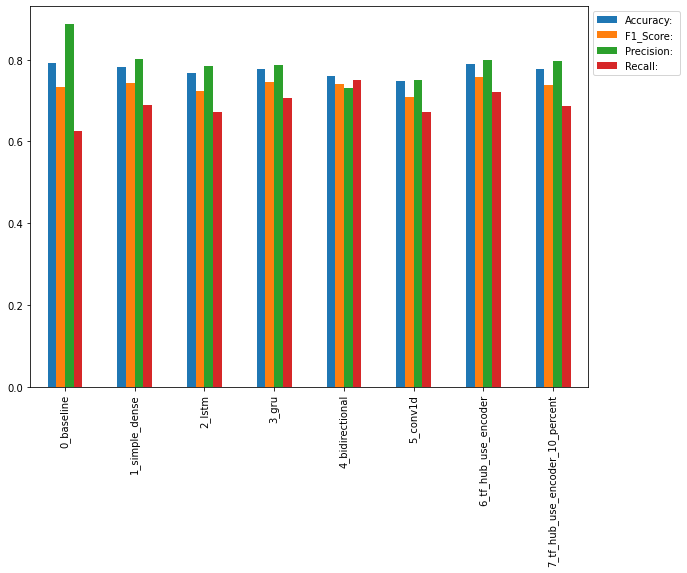

In [151]:
# Plot and compare all of the model results 
all_model_results.plot(kind = 'bar' , figsize = (10 , 7)).legend(bbox_to_anchor = (1.0 , 1.0))


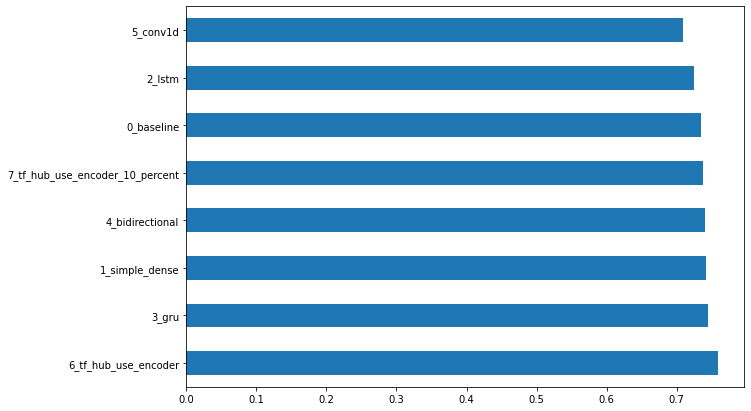

In [152]:
# Sort models results by f1-scores 
all_model_results.sort_values('F1_Score: ' , ascending = False)['F1_Score: '].plot(kind = 'barh' , figsize = (10 , 7))


### Uploading our model training logs to TensorBoard.dev


In [ ]:
# View TenosrBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records 
!tensorboard dev upload --logdir ./model_logs/ \
  --name 'NLP Modelling Experiments' \
  --description 'Comparing multiple different types of model architecture on the Kaggle disaster tweet classification' \
  --one_shot # Exit the upload once uploading is finished

The TensorBoard is live here ---> https://tensorboard.dev/experiment/aPF2BVNJRwq0aMCkCMxUog/#scalars

In [155]:
# If you need to delete an experiment from TensorBoard, you can run the following
# !tensorboard dev list # Gives list of all experiments 

# To delete the experiment 
#!tensorboard dev delete --experiment_id

## Saving and loading a trained model 

There are two main formats to save a model in TensorFlow: 
1. The HDF5 Format. 
2. The `SaveModel` format (this is the default when using TensorFlow) 


In [157]:
# Our best performing model 
model_6_results

{'Accuracy:': 79.00262467191601,
 'F1_Score: ': 0.7583081570996978,
 'Precision: ': 0.7993630573248408,
 'Recall: ': 0.7212643678160919}

In [158]:
# Save TF Hub sentence encoder model to HDF5 format 
model_6.save('model_6.h5')

In [159]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model('model_6.h5' , 
                                            custom_objects = {'KerasLayer': hub.KerasLayer})

In [160]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences , val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4972 - accuracy: 0.7900


[0.4972369074821472, 0.7900262475013733]

In [161]:
# Check the accuracy value (there will little changes due to precision in computing)
model_6_results

{'Accuracy:': 79.00262467191601,
 'F1_Score: ': 0.7583081570996978,
 'Precision: ': 0.7993630573248408,
 'Recall: ': 0.7212643678160919}

Now let's save to the `SaveModel` format. 

Check this for more information: https://www.tensorflow.org/tutorials/keras/save_and_load

In [162]:
# Save TF Hub Sentence Encoder model to SaveModel format (default)
model_6.save('model_6_SaveModel_format') # no extension 

INFO:tensorflow:Assets written to: model_6_SaveModel_format/assets


INFO:tensorflow:Assets written to: model_6_SaveModel_format/assets


In [163]:
# Load in a model from the SavedModel format 
loaded_model_6_SaveModel_format = tf.keras.models.load_model('model_6_SaveModel_format/')

In [164]:
# Evaluate model on SaveModel format 
loaded_model_6_SaveModel_format.evaluate(val_sentences , val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4972 - accuracy: 0.7900


[0.4972369074821472, 0.7900262475013733]

To download files from google colab workspace 

```
from google.colab import files 
files.download('example.txt')
```

https://stackoverflow.com/questions/48774285/how-to-download-file-created-in-colaboratory-workspace#:~:text=Click%20on%20%3E%20icon.,you%20are%20good%20to%20go.

In [165]:
# Checking the summary 
loaded_model_6_SaveModel_format.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_Layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


## Finding the most wrong examples 

Since we are working on a Binary Classification problem it's obvious our prediction probs are going to between 0 and 1. 

However just because we are using a `sigmoid` activation function, the classes our model is predicting on the negative class (disaster tweets) are going to very close to 0 and for the positive class (not disaster tweets) are going to be very close 1. 

- If our best model still isn't perfect, what example is it getting wrong? 
- And of these wrong examples which ones is it getting *most* wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have label of 0 but our model predicts a prediction prob of 0.999 (which is close to 1) and vice versa. 

And what we are doing here is called **Model Driven Data Exploration** that is we are using our model to know about our data better. Also called as Active Learning. 

In [166]:
# Download a pretrained model from Google storage. 
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-06-06 05:51:48--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   255MB/s    in 3.7s    

2021-06-06 05:51:52 (248 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [167]:
# Import previously trained model from Google Storage 
model_6_pretrained = tf.keras.models.load_model('08_model_6_USE_feature_extractor/')
model_6_pretrained.evaluate(val_sentences , val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [168]:
# Make predictions with the loaded model from GS 
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [171]:
# Create a DataFrame with validation sentences and best performing model predictions labels + probabilities

val_df = pd.DataFrame({'text': val_sentences ,
                       'targets': val_labels , 
                       'pred': model_6_pretrained_preds , 
                       'pred_prob': tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,targets,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [173]:
# Find the wrong predictions and sort by prediction probabilities 
# Comparing our target labels and pred labels
most_wrong = val_df[val_df['targets'] != val_df['pred']].sort_values('pred_prob' , ascending = False)

most_wrong[:10] # These are False Positives

,text,targets,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


This happens because we are using `sigmoid` activation function, so that if our prediction prob is over **0.5** it will predict the label as 1.

Let's remind ourselves of the target labels....

* `0` --> not disaster
* `1` --> disaster

In [181]:
# These are False Negatives
most_wrong.tail()

,text,targets,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [183]:
# Check the false positives (model predicted 1 when should've been 0) 
for row in most_wrong[:10].itertuples():
  _ , text , target , pred , pred_prob = row 
  print(f'Target: {target}, Pred: {pred} , Prob: {pred_prob}')
  print(f'Text:\n{text}\n')
  print('----\n')

Target: 0, Pred: 1.0 , Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0 , Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0 , Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0 , Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0 , Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0 , Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

In [185]:
# Check the False Negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _ , text , target , pred , pred_prob = row 
  print(f'Target: {target}, Pred: {pred} , Prob: {pred_prob}')
  print(f'Text:\n{text}\n')
  print('----\n')

Target: 1, Pred: 0.0 , Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0 , Prob: 0.055075809359550476
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0 , Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0 , Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0 , Prob: 0.04963728412985802
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0 , Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0 , 

## Making predictions on the test dataset 

In [191]:
# Our test dataframe 
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [190]:
test_sentences = test_df['text']
test_sentences = test_sentences.to_list()
len(test_sentences) , len(val_sentences)

(3263, 762)

In [193]:
# Getting the pred probs
test_pred_probs = model_6_pretrained.predict(test_sentences)

# Converting them into labels of predictions 
test_preds = tf.squeeze(tf.round(test_pred_probs))
test_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [197]:
pd.Series(test_preds).value_counts()

0.0    2049
1.0    1214
dtype: int64

In [200]:
# Building a dataframe with our test sentences with preds aside 

test_df_performance = pd.DataFrame({'text': test_sentences , 
                                    'pred_probs': tf.squeeze(test_pred_probs) , 
                                    'preds': test_preds})
test_df_performance.head()

,text,pred_probs,preds
0,Just happened a terrible car crash,0.519970,1.0
1,"Heard about #earthquake is different cities, s...",0.875251,1.0
2,"there is a forest fire at spot pond, geese are...",0.827833,1.0
3,Apocalypse lighting. #Spokane #wildfires,0.933507,1.0
4,Typhoon Soudelor kills 28 in China and Taiwan,0.967958,1.0


In [209]:
# Visualizing by tweet and their preds / pred_probs 
test_samples = random.sample(test_sentences , 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f'Pred: {int(pred)} , Prob: {pred_prob}')
  print(f'Text:\n{test_sample}\n')
  print(f'------\n')

Pred: 1 , Prob: 0.9806947708129883
Text:
Aya KanoÛªs family has taken two nuclear hits: First #Hiroshima. Then #Fukushima. http://t.co/kcx9w2EJ8A http://t.co/aC50jw3Xmw

------

Pred: 0 , Prob: 0.07694442570209503
Text:
Economic Wisdom ÛÒ Great Economists Demolish Establishment Nonsense http://t.co/H8NKtqU5O9 The Case for #Logic and #Reason

------

Pred: 0 , Prob: 0.2263944298028946
Text:
A new favorite: Hardwell &amp; Dannic - Survivors (Remake) [FLP Family] by @FLP_Family https://t.co/yGVMztP1rt on #SoundCloud

------

Pred: 1 , Prob: 0.9593697190284729
Text:
One Year After Massacre IraqÛªs Yazidis a Broken People http://t.co/pHqK28doni

------

Pred: 1 , Prob: 0.9491786956787109
Text:
Striking views of Super Typhoon Soudelor as it tracks toward Taiwan China http://t.co/hsjp6Hoffe

------

Pred: 1 , Prob: 0.6810218095779419
Text:
Is it time to hedge against catastrophic risks such as climate change asteroid impacts or bioterrorism? https://t.co/HQ6WqsgSJX

------

Pred: 0 , Prob:

### Predicting on tweets from the wild 

Grabbing tweets from the wild and making our model to make predictions on it. 

In [226]:
daniel_tweets = ['Fight your friends more often' , 
                 'ML/math tidbit that took me a long time to realise Why is "X" a capital and "y" not? • X (often features) is typically a matrix so the convention is to use an uppercase letter • y (often labels) is typically a vector so the convention is to use a lowercase letter' , 
                 'Friends, the latest issue of Machine Learning Monthly has been delivered with grace to your inboxes.' , 
                 'That guy at the gym who comes up to you and says "wait til you get to my age"',
                 'Money describes wealth like words describe reality.' , 
                 'Closing all the extra tabs in your browser is the digital version of Friday afternoon' , 
                 'Been raining here. Haven’t seen the sun in ~3-4 days. Feel like I’m running on 73% energy.No sun messes with you']

daniel_tweets_target = [0 , 0 , 0 , 0 , 0 , 0 , 0]


In [233]:
daniel_tweets_pred_probs = model_6_pretrained.predict(daniel_tweets)
daniel_tweets_preds = tf.squeeze(tf.round(daniel_tweets_pred_probs))

daniel_tweets_preds

<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [234]:
# Creating a dataframe with tweets , targets , pred and pred_probs 

daniel_df = pd.DataFrame({'text': daniel_tweets , 
                          'target': daniel_tweets_target , 
                          'pred': daniel_tweets_preds , 
                          'pred_probs': tf.squeeze(daniel_tweets_pred_probs)})
daniel_df

,text,target,pred,pred_probs
0,Fight your friends more often,0,0.0,0.031134
1,ML/math tidbit that took me a long time to rea...,0,0.0,0.082705
2,"Friends, the latest issue of Machine Learning ...",0,0.0,0.043992
3,That guy at the gym who comes up to you and sa...,0,0.0,0.026416
4,Money describes wealth like words describe rea...,0,0.0,0.057142
5,Closing all the extra tabs in your browser is ...,0,0.0,0.082519
6,Been raining here. Haven’t seen the sun in ~3-...,0,0.0,0.312030
